In [1]:
from os import chdir
chdir("../general")
from models import *
from observation import *
from util import *
chdir("../case-studies")

In [2]:
from fenics import *

import numpy as np
from numpy import random
from numpy import linalg as linalg
from scipy import sparse
from scipy import stats
from scipy.sparse import linalg as splinalg

from sksparse import cholmod as ch
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.axes_grid1 import make_axes_locatable

from decimal import Decimal
import time

In [3]:
def pprint(num):
	print('%.2E' % Decimal(num))

In [4]:
# Create mesh and define function space
xL = -10
xR = 20
expand = 5
num_pt = 100
mesh = IntervalMesh(num_pt,xL-expand,xR+expand)
V = FunctionSpace(mesh, 'P', 1)
fem = V.element()
interior = Expression("x[0] >= -10 & x[0] <= 20 ? 1 : 0",degree=1,domain=mesh)

In [5]:
# Define our source problem parameters
alpha = 4			  # twice the number of recursive applications
d = 1				  # dimension of the space
nu = alpha-d/2		  # matern nu parameter
rho = 5  			  # range
kappa = 8*nu/rho**2   # matern kappa parameter
sigma2 = 10           # variance of the source
tau = 2               # time scale of the source

In [6]:
# Define our mechanics problem parameters
T = 100
diff = 0.25
diffusion = Constant(diff)
dec = 0.05
decay = Constant(dec)
advection = Expression("1 + 0.2*cos(6.283*x[0]/10) + 0.15*cos(9.425*x[0]/10) + 0.15*cos(15.708*x[0]/10)",degree=2,domain=mesh)
def adv(x):
	return 1 + 0.2*np.cos(6.283*x/10) + 0.15*cos(9.425*x/10) + 0.15*cos(15.708*x/10)
adv0 = str(adv(xL))
adv1 = str(adv(xR))
strL = "(" + str(xL) + ")"
strR = "(" + str(xR) + ")"
termL = "(" + strR + "-x[0])/(" + strR + "-" + strL + ")"
termR = "(x[0] - " + strL +")/(" + strR + "-" + strL + ")"
adv_BC = Expression("-" + adv0 + "*" + termL + " + " + adv1 + "*" + termR,degree=1,domain=mesh)

In [7]:
# Get the source problem matrices
u = TrialFunction(V)
v = TestFunction(V)
equation = (kappa**2/tau)*u*v*dx + (1/tau)*inner(grad(u), grad(v))*dx # the diffusion term has flipped sign due to int-by-parts
mass = inner(u,v)*dx

In [8]:
# Assemble source matrices
K = assemble(equation)
K = as_backend_type(K).mat()
(m,n) = K.size
K_source = sparse.csr_matrix(K.getValuesCSR()[::-1],shape=K.size)

L = assemble(mass)
L = as_backend_type(L).mat()
(m,n) = L.size
L_source = sparse.csr_matrix(L.getValuesCSR()[::-1],shape=L.size)
invL_source = sparse.spdiags(1/L_source.sum(axis=0),0,m,n)

In [9]:
invLK_source = invL_source @ K_source
diag_source = invLK_source[0,0]

In [10]:
# Get the mechanics problem matrices
u = TrialFunction(V)
v = TestFunction(V)
equation = diffusion*u.dx(0)*v.dx(0)*dx + advection.dx(0)*u*v*dx + advection*u.dx(0)*v*dx + decay*u*v*dx # - adv_BC*u*v*ds # need the robin BC here if we want to control conservation of mass
mass = u*v*dx

In [11]:
# Assemble precision matrices
K = assemble(equation)
K = as_backend_type(K).mat()
(m,n) = K.size
K = sparse.csr_matrix(K.getValuesCSR()[::-1],shape=K.size)

L = assemble(mass)
L = as_backend_type(L).mat()
(m,n) = L.size
L = sparse.csr_matrix(L.getValuesCSR()[::-1],shape=L.size)
invL = sparse.spdiags(1/L.sum(axis=0),0,m,n)
sqrt_invL = sparse.spdiags(1/np.sqrt(L.sum(axis=0)),0,m,n)

invLK = invL @ K
diag = invLK[0,0]
dt = 1/(2*max(diag_source,diag))
# backward euler
M_source = sparse.eye(m) + dt*invLK_source
M = sparse.eye(m) + dt*invLK

In [12]:
# obtain a simulated source vector
N_t,N_x = int(np.ceil(T/dt)),num_pt+1

In [13]:
Lkron = sparse.kron(sparse.eye(N_t),sparse.spdiags(L.sum(axis=0),0,N_x,N_x))
inv_Lkron = sparse.kron(sparse.eye(N_t),sparse.spdiags(1/L.sum(axis=0),0,N_x,N_x))
sqrt_inv_Lkron = sparse.kron(sparse.eye(N_t),sparse.spdiags(1/np.sqrt(L.sum(axis=0)),0,N_x,N_x))

In [14]:
# forward euler
R_source = sparse.eye(N_t*N_x) - sparse.kron(sparse.spdiags(np.ones(N_t-1),-1,N_t,N_t),M_source)
R_source /= dt
R_proc = sparse.eye(N_t*N_x) - sparse.kron(sparse.spdiags(np.ones(N_t-1),-1,N_t,N_t),M)
R_proc /= dt

# backward euler
R_source = sparse.kron(sparse.eye(N_t),M_source) - sparse.kron(sparse.spdiags(np.ones(N_t-1),-1,N_t,N_t),sparse.eye(N_x))
R_source /= dt
R_proc = sparse.kron(sparse.eye(N_t),M) - sparse.kron(sparse.spdiags(np.ones(N_t-1),-1,N_t,N_t),sparse.eye(N_x))
R_proc /= dt

print(R_source[0,1])
print(R_source[1,0])

-6.040933333333375
-3.020466666666688


In [15]:
# Construct the source function
source_vec = sqrt_inv_Lkron @ random.normal(size=N_t*N_x)
for i in range(alpha//2):
	# if forward euler
    #source_vec = splinalg.spsolve_triangular(R_source, source_vec)
    
    # if backward euler
    source_vec = splinalg.spsolve(R_source,source_vec)
source = source_vec.reshape((N_t,N_x))

In [16]:
# Solve for the steady state (w)

# if forward euler
#wt_vec = splinalg.spsolve_triangular(R_proc,source_vec)

# if backward euler
wt_vec = splinalg.spsolve(R_proc,source_vec)
wt = wt_vec.reshape((N_t,N_x))

In [17]:
# Get observations
num_samp_x = 10
num_samp_t = 20
sigma2_eps = 1e-6
x      = np.linspace(xL+(xR-xL)/10,xR-(xR-xL)/10,num_samp_x)
t_inds = list(map(int,np.linspace(N_t//10,N_t-N_t//10,num_samp_t)))

In [18]:
true_data = []
for i in t_inds:
	w = vec_to_func(wt[i,:],V)
	true_data += [w(x) for x in x]

In [19]:
data = random.normal(scale=np.sqrt(sigma2_eps),size=num_samp_x*num_samp_t) + true_data

In [20]:
Ox = make_obs_mat_pts([[pt] for pt in x],fem,mesh,V,threshold=1e-10)
Ot = sparse.coo_matrix((np.ones(num_samp_t),(t_inds,range(num_samp_t))),shape=(N_t,num_samp_t))
O = sparse.kron(Ot,Ox).tocsc()
assert np.sum(np.abs(O.transpose()@wt_vec - true_data)) < 1e-5,"O is not the true observation matrix"

In [21]:
Qu = R_source.transpose() @ Lkron @ R_source
Qu = R_source.transpose() @ Qu @ R_source
Qu = R_proc.transpose() @ Qu @ R_proc
Qupost = Qu + O @ O.transpose()/sigma2_eps
Qu_fac = ch.cholesky(Qu)
Qupost_fac = ch.cholesky(Qupost)

In [22]:
def Quinv(v):
	vec = splinalg.spsolve_triangular(R_proc.transpose(),v)
	for i in range(alpha//2):
		vec = splinalg.spsolve_triangular(R_source.transpose(),vec)
	vec = inv_Lkron @ vec
	for i in range(alpha//2):
		vec = splinalg.spsolve_triangular(R_source,vec)
	vec = splinalg.spsolve_triangular(R_proc,v)
	return vec

test1 = O @ data / sigma2_eps
test2 = Qupost_fac.solve_A(test1)
test3 = O @ (data - O.transpose() @ test2) / sigma2_eps
mean_soln_vec  = Qu_fac.solve_A(test3)
mean_source_vec = R_proc @ mean_soln_vec
mean_soln  = mean_soln_vec.reshape((N_t,N_x))
mean_source = mean_source_vec.reshape((N_t,N_x))

In [23]:
tfrac = 15

x_plots = np.tile((6*N_x//8)*(x+10)/30,num_samp_t) # this converts from x (the actual coordinates) to indices for plotting
t_plots = np.repeat(np.array(t_inds)/tfrac,len(x)) # this downsamples from t_inds by tfrac for plotting



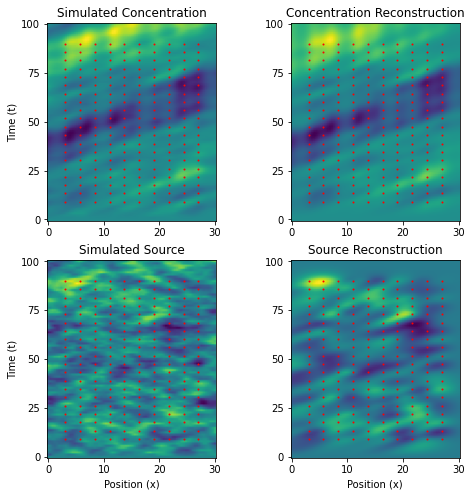

In [24]:
# note that we are not plotting this on the same x-units we simulated with for some reason
# we're also only plotting every tfrac-th row for computation/visualization reasons

plt.figure(figsize=(8,8))
plt.subplot(2,2,1)
plt.imshow(wt[list(reversed(range(0,N_t,tfrac))),:][:,list(reversed(range(N_x//8,7*N_x//8)))])
plt.scatter(x=x_plots,y=t_plots,s=1,c="red")
plt.title("Simulated Concentration")
plt.ylabel("Time (t)")
plt.xticks([0,25,50,75],["0","10","20","30"])
plt.yticks([0,N_t/4//tfrac,N_t/2//tfrac,3*N_t/4//tfrac,N_t//tfrac],["100","75","50","25","0"])
plt.subplot(2,2,2)
plt.imshow(mean_soln[list(reversed(range(0,N_t,tfrac))),:][:,list(reversed(range(N_x//8,7*N_x//8)))])
plt.scatter(x=x_plots,y=t_plots,s=1,c="red")
plt.title("Concentration Reconstruction")
plt.xticks([0,25,50,75],["0","10","20","30"])
plt.yticks([0,N_t/4//tfrac,N_t/2//tfrac,3*N_t/4//tfrac,N_t//tfrac],["100","75","50","25","0"])
plt.subplot(2,2,3)
plt.imshow(source[list(reversed(range(0,N_t,tfrac))),:][:,list(reversed(range(N_x//8,7*N_x//8)))])
plt.title("Simulated Source")
plt.xlabel("Position (x)")
plt.ylabel("Time (t)")
plt.scatter(x=x_plots,y=t_plots,s=1,c="red")
plt.xticks([0,25,50,75],["0","10","20","30"])
plt.yticks([0,N_t/4//tfrac,N_t/2//tfrac,3*N_t/4//tfrac,N_t//tfrac],["100","75","50","25","0"])
plt.subplot(2,2,4)
plt.imshow(mean_source[list(reversed(range(0,N_t,tfrac))),:][:,list(reversed(range(N_x//8,7*N_x//8)))])
plt.title("Source Reconstruction")
plt.xlabel("Position (x)")
plt.scatter(x=x_plots,y=t_plots,s=1,c="red")
plt.xticks([0,25,50,75],["0","10","20","30"])
plt.yticks([0,N_t/4//tfrac,N_t/2//tfrac,3*N_t/4//tfrac,N_t//tfrac],["100","75","50","25","0"])
plt.show()

In [25]:
# calculate a simultaneous confidence interval from a sparse precision matrix
def simultaneous_confint_prec(fac,dim,num_sim,R=None,p=0.05):

	chi2k = stats.chi2(df=dim)
	thresh = chi2k.ppf(1-p)

	sims = random.normal(size=(num_sim,dim))
	sim_mags = np.sum(sims**2,axis=1)
	for i in range(num_sim):
		sims[i,:] = fac.apply_Pt(fac.solve_Lt(sims[i,:],use_LDLt_decomposition=False))
	if R is not None:
		for i in range(num_sim):
			sims[i,:] = R @ sims[i,:]
	std = np.std(sims,axis=0)

	sims_scaled = sims*thresh/std
	for i in range(num_sim):
		sims_scaled[i,:] /= sim_mags[i]

	return std*np.max(sims_scaled)

sim_confint_proc_vec = simultaneous_confint_prec(Qupost_fac,N_t*N_x,1000,p=0.05)
sim_confint_source_vec = simultaneous_confint_prec(Qupost_fac,N_t*N_x,1000,p=0.05,R=R_proc)
sim_confint_proc = sim_confint_proc_vec.reshape((N_t,N_x))
sim_confint_source = sim_confint_source_vec.reshape((N_t,N_x))
print(np.max((mean_soln-wt)/sim_confint_proc))
print(np.max((mean_source-source)/sim_confint_source))

0.6577005874785574
0.6939052361766394


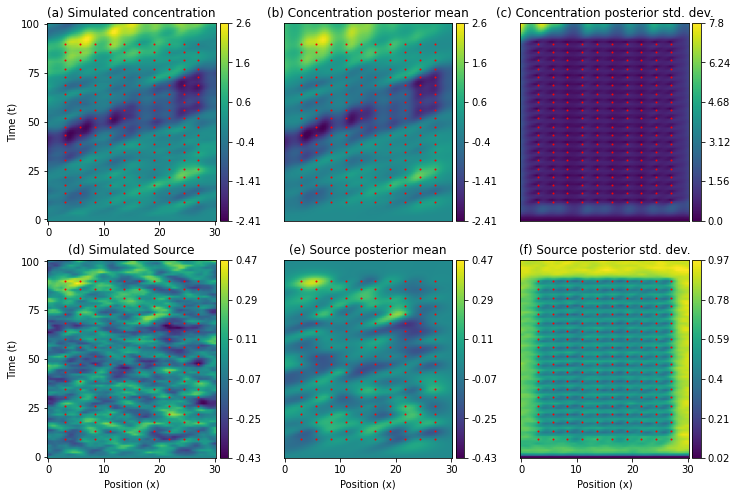

In [26]:
plt.figure(figsize=(12,8))

ax = plt.subplot(2,3,1)
plt.imshow(wt[list(reversed(range(0,N_t,tfrac))),:][:,list(reversed(range(N_x//8,7*N_x//8)))])
plt.title("(a) Simulated concentration")
plt.ylabel("Time (t)")
plt.xticks([0,25,50,75],["0","10","20","30"])
plt.yticks([0,N_t/4//tfrac,N_t/2//tfrac,3*N_t/4//tfrac,N_t//tfrac],["100","75","50","25","0"])
c = ax.scatter(x=x_plots,y=t_plots,s=1,c="red")
divider = make_axes_locatable(ax)
cax = divider.append_axes("right",size="5%",pad=0.05)
cbar = plt.colorbar(c,cax=cax)
cbar.set_ticks(np.linspace(0,1,6,endpoint=True))
cbar.set_ticklabels(np.round(np.linspace(np.min(wt),np.max(wt),6,endpoint=True),2))

ax = plt.subplot(2,3,2)
plt.imshow(mean_soln[list(reversed(range(0,N_t,tfrac))),:][:,list(reversed(range(N_x//8,7*N_x//8)))],vmin=np.min(wt),vmax=np.max(wt))
plt.title("(b) Concentration posterior mean")
plt.tick_params(axis="both",which="both",bottom=False,left=False,labelbottom=False,labelleft=False)
c = ax.scatter(x=x_plots,y=t_plots,s=1,c="red")
divider = make_axes_locatable(ax)
cax = divider.append_axes("right",size="5%",pad=0.05)
cbar = plt.colorbar(c,cax=cax)
cbar.set_ticks(np.linspace(0,1,6,endpoint=True))
cbar.set_ticklabels(np.round(np.linspace(np.min(wt),np.max(wt),6,endpoint=True),2))

ax = plt.subplot(2,3,3)
plt.imshow(sim_confint_proc[list(reversed(range(0,N_t,tfrac))),:][:,list(reversed(range(N_x//8,7*N_x//8)))])
plt.title("(c) Concentration posterior std. dev.")
plt.tick_params(axis="both",which="both",bottom=False,left=False,labelbottom=False,labelleft=False)
c = ax.scatter(x=x_plots,y=t_plots,s=1,c="red")
divider = make_axes_locatable(ax)
cax = divider.append_axes("right",size="5%",pad=0.05)
cbar = plt.colorbar(c,cax=cax)
cbar.set_ticks(np.linspace(0,1,6,endpoint=True))
cbar.set_ticklabels(np.round(np.linspace(np.min(sim_confint_proc),np.max(sim_confint_proc),6,endpoint=True),2))

ax = plt.subplot(2,3,4)
plt.imshow(source[list(reversed(range(0,N_t,tfrac))),:][:,list(reversed(range(N_x//8,7*N_x//8)))])
plt.title("(d) Simulated Source")
plt.xlabel("Position (x)")
plt.ylabel("Time (t)")
plt.xticks([0,25,50,75],["0","10","20","30"])
plt.yticks([0,N_t/4//tfrac,N_t/2//tfrac,3*N_t/4//tfrac,N_t//tfrac],["100","75","50","25","0"])
c = ax.scatter(x=x_plots,y=t_plots,s=1,c="red")
divider = make_axes_locatable(ax)
cax = divider.append_axes("right",size="5%",pad=0.05)
cbar = plt.colorbar(c,cax=cax)
cbar.set_ticks(np.linspace(0,1,6,endpoint=True))
cbar.set_ticklabels(np.round(np.linspace(np.min(source),np.max(source),6,endpoint=True),2))

ax = plt.subplot(2,3,5)
plt.imshow(mean_source[list(reversed(range(0,N_t,tfrac))),:][:,list(reversed(range(N_x//8,7*N_x//8)))],vmin=np.min(source),vmax=np.max(source))
plt.title("(e) Source posterior mean")
plt.xlabel("Position (x)")
plt.xticks([0,25,50,75],["0","10","20","30"])
plt.tick_params(axis="y",which="both",left=False,labelleft=False)
c = ax.scatter(x=x_plots,y=t_plots,s=1,c="red")
divider = make_axes_locatable(ax)
cax = divider.append_axes("right",size="5%",pad=0.05)
cbar = plt.colorbar(c,cax=cax)
cbar.set_ticks(np.linspace(0,1,6,endpoint=True))
cbar.set_ticklabels(np.round(np.linspace(np.min(source),np.max(source),6,endpoint=True),2))

ax = plt.subplot(2,3,6)
plt.imshow(sim_confint_source[list(reversed(range(0,N_t,tfrac))),:][:,list(reversed(range(N_x//8,7*N_x//8)))])
plt.title("(f) Source posterior std. dev.")
plt.xlabel("Position (x)")
plt.xticks([0,25,50,75],["0","10","20","30"])
plt.tick_params(axis="y",which="both",left=False,labelleft=False)
c = ax.scatter(x=x_plots,y=t_plots,s=1,c="red")
divider = make_axes_locatable(ax)
cax = divider.append_axes("right",size="5%",pad=0.05)
cbar = plt.colorbar(c,cax=cax)
cbar.set_ticks(np.linspace(0,1,6,endpoint=True))
cbar.set_ticklabels(np.round(np.linspace(np.min(sim_confint_source),np.max(sim_confint_source),6,endpoint=True),2))

plt.show()

In [27]:
np.max(wt)

2.6008320888897343

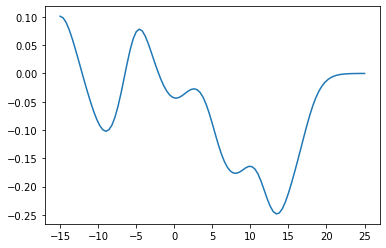

In [28]:
plot(vec_to_func(mean_source[850,],V))

In [29]:
soln_est_fs = [vec_to_func(mean_soln[i,],V) for i in range(N_t)]
soln_fs = [vec_to_func(wt[i,],V) for i in range(N_t)]
source_est_fs = [vec_to_func(mean_source[i,],V) for i in range(N_t)]
source_fs = [vec_to_func(source[i,],V) for i in range(N_t)]

const1 = Expression("1",degree=1)
const1_f = Function(V)
const1_f.interpolate(const1)
shifted_source_fs = [source_f - assemble(source_f*interior*dx)/assemble(const1_f*interior*dx) for source_f in source_fs]
shifted_soln_fs = [soln_f - assemble(soln_f*interior*dx)/assemble(const1_f*interior*dx) for soln_f in soln_fs]

In [30]:
L2s_source = [np.sqrt(assemble((source_fs[i] - source_est_fs[i])**2*interior*dx)) for i in range(N_t)]
L2s_soln = [np.sqrt(assemble((soln_fs[i] - soln_est_fs[i])**2*interior*dx)) for i in range(N_t)]
#scaled_L2s_source = [np.sqrt(assemble((source_fs[i] - source_est_fs[i])**2*interior*dx))/np.sqrt(assemble(shifted_source_fs[i]**2*interior*dx)) for i in range(N_t)]
#scaled_L2s_soln = [np.sqrt(assemble((soln_fs[i] - soln_est_fs[i])**2*interior*dx))/np.sqrt(assemble(shifted_soln_fs[i]**2*interior*dx)) for i in range(N_t)]

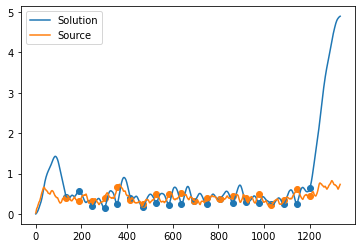

In [31]:
t_plot = [i for i in range(N_t) if i in t_inds]

ax=plt.gca()
ax.plot(L2s_soln,label="Solution")
ax.plot(L2s_source,label="Source")
ax.scatter(x=t_plot,y=[L2s_soln[i] for i in t_plot])
ax.scatter(x=t_plot,y=[L2s_source[i] for i in t_plot])
ax.legend()
plt.show()

In [32]:
# TODO test these?
# this treats sigma2_eps, Qu_fac, R_proc as globals.....
def soln_and_source_error(num_samp_t,num_samp_x,source_mat,soln_mat):
    
    x      = np.linspace(xL+(xR-xL)/10,xR-(xR-xL)/10,num_samp_x)
    t_inds = list(map(int,np.linspace(N_t//10,N_t-N_t//10,num_samp_t)))
    
    Ox = make_obs_mat_pts([[pt] for pt in x],fem,mesh,V,threshold=1e-10)
    Ot = sparse.coo_matrix((np.ones(num_samp_t),(t_inds,range(num_samp_t))),shape=(N_t,num_samp_t))
    O = sparse.kron(Ot,Ox).tocsc()
    
    Qupost = Qu + O @ O.transpose()/sigma2_eps
    Qupost_fac = ch.cholesky(Qupost)
    
    true_data = []
    for i in t_inds:
        soln_f = vec_to_func(soln_mat[i,:],V)
        true_data += [soln_f(x) for x in x]
    data = random.normal(scale=np.sqrt(sigma2_eps),size=num_samp_x*num_samp_t) + true_data
    
    test1 = O @ data / sigma2_eps
    test2 = Qupost_fac.solve_A(test1)
    test3 = O @ (data - O.transpose() @ test2) / sigma2_eps
    soln_est_vec  = Qu_fac.solve_A(test3)
    source_est_vec = R_proc @ soln_est_vec
    soln_est_mat  = soln_est_vec.reshape((N_t,N_x))
    source_est_mat = source_est_vec.reshape((N_t,N_x))
    
    soln_est_fs = [vec_to_func(soln_est_mat[i,],V) for i in range(N_t)]
    soln_fs = [vec_to_func(soln_mat[i,],V) for i in range(N_t)]
    source_est_fs = [vec_to_func(source_est_mat[i,],V) for i in range(N_t)]
    source_fs = [vec_to_func(source_mat[i,],V) for i in range(N_t)]

#     const1 = Expression("1",degree=1)
#     const1_f = Function(V)
#     const1_f.interpolate(const1)
#     shifted_source_fs = [source_f - assemble(source_f*interior*dx)/assemble(const1_f*interior*dx) for source_f in source_fs]
#     shifted_soln_fs = [soln_f - assemble(soln_f*interior*dx)/assemble(const1_f*interior*dx) for soln_f in soln_fs]

#     relative_error_source = [np.sqrt(assemble((source_fs[i] - source_est_fs[i])**2*interior*dx))/np.sqrt(assemble(shifted_source_fs[i]**2*interior*dx)) for i in range(N_t)]
#     relative_error_soln = [np.sqrt(assemble((soln_fs[i] - soln_est_fs[i])**2*interior*dx))/np.sqrt(assemble(shifted_soln_fs[i]**2*interior*dx)) for i in range(N_t)]
    
    error_source = [np.sqrt(assemble((source_fs[i] - source_est_fs[i])**2*interior*dx)) for i in range(N_t)]
    error_soln = [np.sqrt(assemble((soln_fs[i] - soln_est_fs[i])**2*interior*dx)) for i in range(N_t)]
    
    return error_source,error_soln

def sim_soln_and_source_error(num_samps,num_sim=1):
    
    if num_sim==1:
        source_vec = sqrt_inv_Lkron @ random.normal(size=N_t*N_x)
        for i in range(alpha//2):
            # if forward euler
            #source_vec = splinalg.spsolve_triangular(R_source, source_vec)

            # if backward euler
            source_vec = splinalg.spsolve(R_source,source_vec)
        source = source_vec.reshape((N_t,N_x))
        soln_vec = splinalg.spsolve(R_proc,source_vec)
        soln = soln_vec.reshape((N_t,N_x))
        return np.array([soln_and_source_error(num_samp_t,num_samp_x,source,soln) for (num_samp_t,num_samp_x) in num_samps])
    else:
        return [sim_soln_and_source_error(num_samps) for i in range(num_sim)]
    # returns a list of simulations
    # each simulation has dimension num_samps x 2 (source+soln) x space size

In [33]:
errors_by_space = sim_soln_and_source_error([(20,5**x) for x in range(6)],num_sim=5)

In [34]:
errors_by_time = sim_soln_and_source_error([(5**x,20) for x in range(6)],num_sim=5)

In [35]:
errors_by_both = sim_soln_and_source_error([(5**x,5**x) for x in range(6)],num_sim=5)

In [36]:
errors_by_space

[array([[[2.63860482e-02, 5.22410062e-02, 7.28028632e-02, ...,
          4.59558896e-01, 4.55044456e-01, 4.55285237e-01],
         [1.81884532e-03, 5.19472167e-03, 9.81381572e-03, ...,
          3.06013131e+00, 3.06040193e+00, 3.05953629e+00]],
 
        [[2.65220831e-02, 5.21648632e-02, 7.22336914e-02, ...,
          4.59380991e-01, 4.54697045e-01, 4.54762278e-01],
         [1.82992379e-03, 5.20420801e-03, 9.78666779e-03, ...,
          3.20510026e+00, 3.20016422e+00, 3.19376600e+00]],
 
        [[2.65457968e-02, 5.21461588e-02, 7.21467190e-02, ...,
          4.59264618e-01, 4.54558563e-01, 4.54615382e-01],
         [1.83181506e-03, 5.20526986e-03, 9.78184635e-03, ...,
          3.29568674e+00, 3.29156154e+00, 3.28598511e+00]],
 
        [[2.65432292e-02, 5.21376612e-02, 7.20981912e-02, ...,
          4.59358997e-01, 4.54652897e-01, 4.54706951e-01],
         [1.83157768e-03, 5.20419074e-03, 9.77685357e-03, ...,
          3.46503575e+00, 3.46201133e+00, 3.45754770e+00]],
 
        [[2.

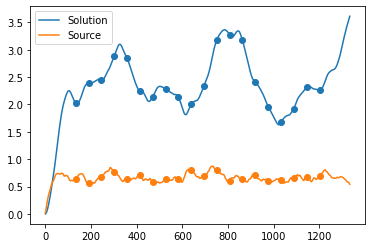

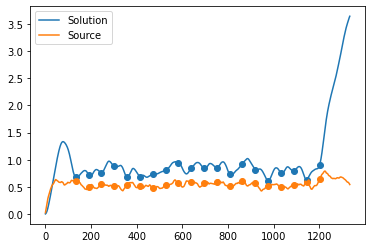

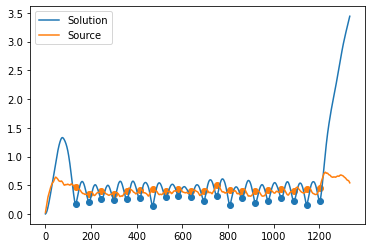

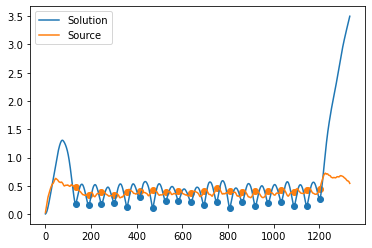

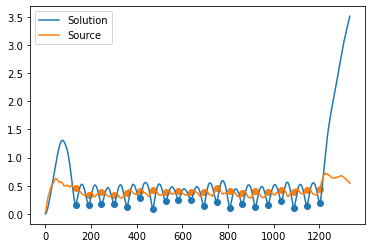

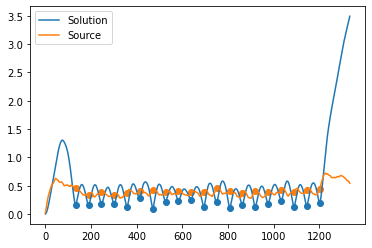

In [37]:
avg_errors = np.mean(errors_by_space,axis=0)
avg_errors
source_errors = avg_errors[:,0,:]
soln_errors = avg_errors[:,1,:]
nx = [5**x for x in range(6)]

for j in range(6):
    t_inds = list(map(int,np.linspace(N_t//10,N_t-N_t//10,20)))
    t_plot = [i for i in range(N_t) if i in t_inds]

    ax=plt.gca()
    ax.plot(soln_errors[j,:],label="Solution")
    ax.plot(source_errors[j,:],label="Source")
    ax.scatter(x=t_plot,y=[soln_errors[j,:][i] for i in t_plot])
    ax.scatter(x=t_plot,y=[source_errors[j,:][i] for i in t_plot])
    ax.legend()
    plt.show()

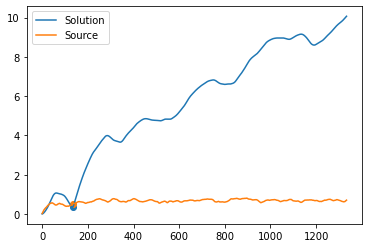

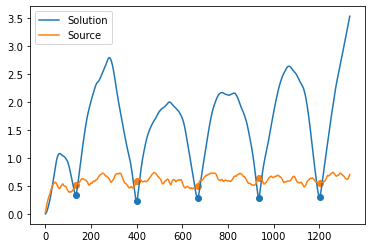

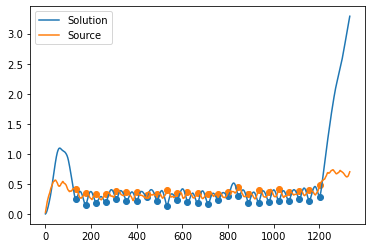

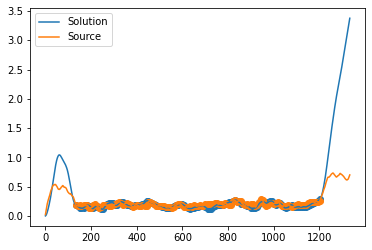

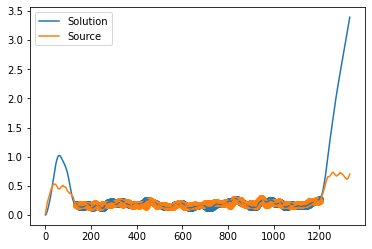

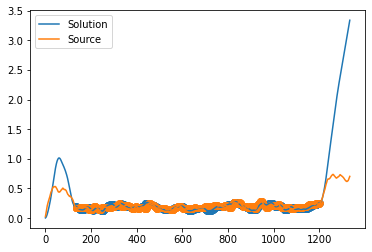

In [38]:
avg_errors = np.mean(errors_by_time,axis=0)
avg_errors
source_errors = avg_errors[:,0,:]
soln_errors = avg_errors[:,1,:]
nt = [5**x for x in range(6)]

for j in range(6):
    t_inds = list(map(int,np.linspace(N_t//10,N_t-N_t//10,nt[j])))
    t_plot = [i for i in range(N_t) if i in t_inds]

    ax=plt.gca()
    ax.plot(soln_errors[j,:],label="Solution")
    ax.plot(source_errors[j,:],label="Source")
    ax.scatter(x=t_plot,y=[soln_errors[j,:][i] for i in t_plot])
    ax.scatter(x=t_plot,y=[source_errors[j,:][i] for i in t_plot])
    ax.legend()
    plt.show()

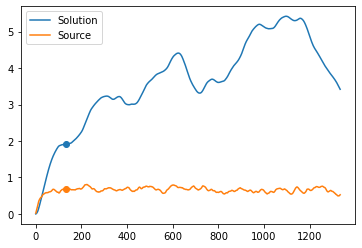

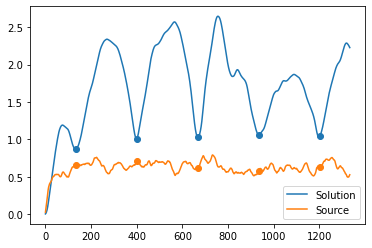

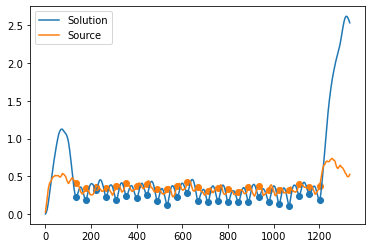

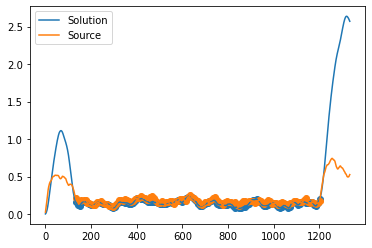

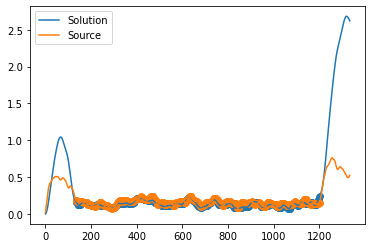

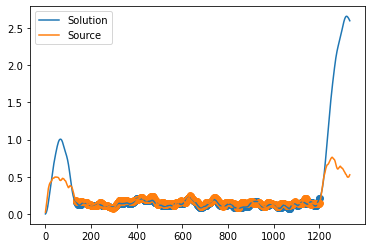

In [39]:
avg_errors = np.mean(errors_by_both,axis=0)
avg_errors
source_errors = avg_errors[:,0,:]
soln_errors = avg_errors[:,1,:]
nt = [5**x for x in range(6)]

for j in range(6):
    t_inds = list(map(int,np.linspace(N_t//10,N_t-N_t//10,nt[j])))
    t_plot = [i for i in range(N_t) if i in t_inds]

    ax=plt.gca()
    ax.plot(soln_errors[j,:],label="Solution")
    ax.plot(source_errors[j,:],label="Source")
    ax.scatter(x=t_plot,y=[soln_errors[j,:][i] for i in t_plot])
    ax.scatter(x=t_plot,y=[source_errors[j,:][i] for i in t_plot])
    ax.legend()
    plt.show()

In [40]:
avg_source_errors = [np.mean([source_errors[i,j] for j in range(N_t//10,N_t-N_t//10)]) for i in range(6)]
avg_soln_errors = [np.mean([soln_errors[i,j] for j in range(N_t//10,N_t-N_t//10)]) for i in range(6)]

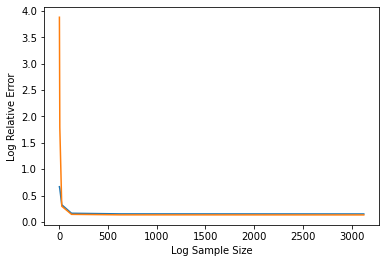

In [41]:
ax = plt.gca()
ax.plot([5**x for x in range(6)],avg_source_errors)
ax.plot([5**x for x in range(6)],avg_soln_errors)
ax.set_ylabel("Log Relative Error")
ax.set_xlabel("Log Sample Size")
plt.show()

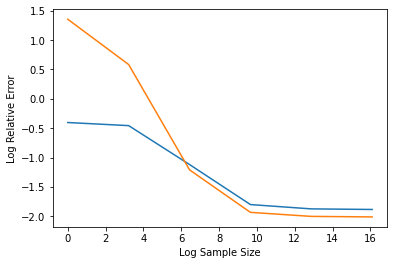

In [42]:
ax = plt.gca()
ax.plot(2*np.log([5**x for x in range(6)]),np.log(avg_source_errors))
ax.plot(2*np.log([5**x for x in range(6)]),np.log(avg_soln_errors))
ax.set_ylabel("Log Relative Error")
ax.set_xlabel("Log Sample Size")
plt.show()